In [6]:
# preprocessing part
import re
import pickle
import json
import spacy
from spacy import load
import numpy as np
from nltk.stem.snowball import RussianStemmer

# tokenization part
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classification part
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (balanced_accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay
                             )

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

#other 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

### 1. Препроцессинг

In [ ]:
ru_nlp = load("ru_core_news_lg")
stemmer = RussianStemmer()

EXCLUDE_SYMBOLS_STR = u''.join(['№', '«', 'ђ', '°', '±', '‚', 'ћ', '‰', '…', '»', 'ѓ', 'µ', '·', 'ґ', 'њ', 'ї', 'џ', 'є', '‹',
                                '‡', '†', '¶', 'ќ', '€', '“', 'ў', '§', '„', '”', '\ufeff', '’', 'љ', '›', '•', '—', '‘', 
                                '\x7f', '\xad', '¤', '\xa0'])
exluded_pattern = re.compile('[%s]' % re.escape(EXCLUDE_SYMBOLS_STR))
whitespaces_pattern = re.compile(r'\s+')
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002500-\U00002BEF"  # chinese char
                           u"\U00002702-\U000027B0"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001f926-\U0001f937"
                           u"\U00010000-\U0010ffff"
                           u"\u2640-\u2642"
                           u"\u2600-\u2B55"
                           u"\u200d"
                           u"\u23cf"
                           u"\u23e9"
                           u"\u231a"
                           u"\ufe0f"  # dingbats
                           u"\u3030"
                           "]+")

In [ ]:
with open('/home/tim/repos/nlp_course/data/habr_small/habr_articles.json', 'r') as fp:
    habr_articles = json.load(fp)

In [ ]:
def preprocess_article(article):
    category = article['category']
    text = article['text'].strip().strip('\t').replace('\n', u'').lower()
    text = emoji_pattern.sub('', text)
    text = exluded_pattern.sub('', text)
    text = whitespaces_pattern.sub(' ', text)
    
    #add suffixes and prefixes searcher
    suffixes = ru_nlp.Defaults.suffixes
    prefixes = ru_nlp.Defaults.prefixes
    suffix_regex = spacy.util.compile_suffix_regex(suffixes)
    prefix_regex = spacy.util.compile_prefix_regex(prefixes)
    ru_nlp.tokenizer.suffix_search = suffix_regex.search
    ru_nlp.tokenizer.prefix_search = prefix_regex.search
    
    document = ru_nlp(text)
    document_llemas = [
        token.lemma_.strip() for token in document if not token.is_stop 
                                    and not token.is_punct 
                                    and not token.is_digit 
                                    and not token.like_url]
                                        
    document_stems = [stemmer.stem(word) for word in document_llemas]
    
    return ' '.join(document_llemas), ' '.join(document_stems), category

In [ ]:
tmp_habr_articles = habr_articles['catalog']

In [ ]:
preprocessed_lemmas, preprocessed_stems, categories = [], [], [] 
for article in tqdm(tmp_habr_articles):
    preprocessed_lemma, preprocessed_stem, y = preprocess_article(article)
    preprocessed_lemmas.append(preprocessed_lemma)
    preprocessed_stems.append(preprocessed_stem) 
    categories.append(y)

In [ ]:
with open('/home/tim/repos/nlp_course/data/habr_small/jsonpreprocessed_lemmas.pkl', 'wb') as f:
    pickle.dump(preprocessed_lemmas, f)
with open('/home/tim/repos/nlp_course/data/habr_small/preprocessed_stems.pkl', 'wb') as f:
    pickle.dump(preprocessed_stems, f)
with open('/home/tim/repos/nlp_course/data/habr_small/categories.pkl', 'wb') as f:
    pickle.dump(categories, f)

### 2. Данные

In [2]:
with open('data/habr_small/preprocessed_stems.pkl', 'rb') as fp:
    preprocessed_stems = pickle.load(fp)
with open('data/habr_small/categories.pkl', 'rb') as fp:
    categories = pickle.load(fp)

In [11]:
class_mapper = {"artificial_intelligence": 0, 
                "hr_management": 1, 
                "physics": 2, 
                "biotech": 3}

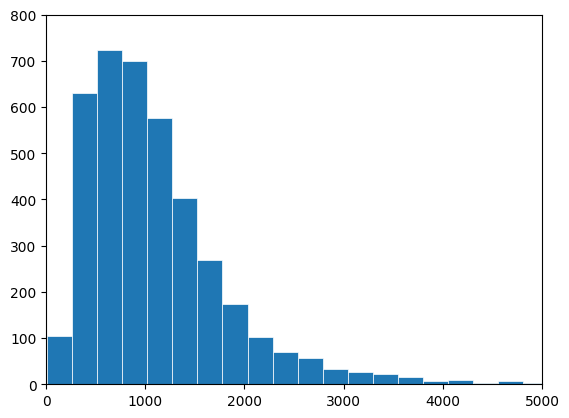

In [3]:
#распределение длин статей по словам
lengths = [len(stem.split()) for stem in preprocessed_stems]

fig, ax = plt.subplots()

ax.hist(lengths, bins=100, linewidth=0.5, edgecolor="white")
ax.set(xlim=(0, 5000), ylim=(0, 800))
plt.plot();

In [7]:
X = TfidfVectorizer().fit_transform(raw_documents=preprocessed_stems)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

In [13]:
scatter_X = [x[0] for x in X_embedded]
scatter_Y = [x[1] for x in X_embedded]
values = [class_mapper[cat] for cat in categories]

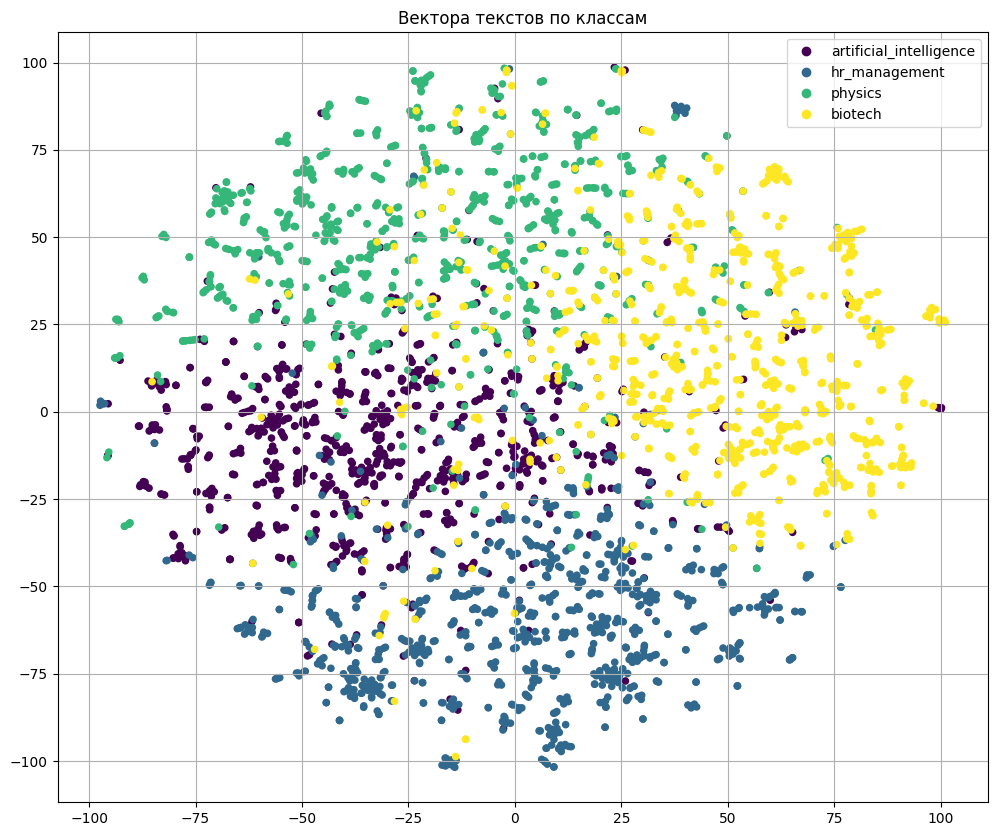

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(scatter_X, scatter_Y, c=values, s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=class_mapper.keys())

plt.title('Вектора текстов по классам')
plt.grid(True)
plt.plot();

#### В целом видно разделение текстов на классы, но есть и те, что сильно заходят в пространство других классов. Это объяснимо тем, что на Хабре (источник для датасета) в статьях из одной категории присутствует теги из других категорий, а значит и информация в статьях может содержаться из двух категориий. При сборе датасета я старался фильтровать и брать таких минимум, но часть их них все равно присутсвует

### Классификация. 
Из-за большой размерности и ограниченности по ресурсам к исходным веткорам после векторизации будет применяться PCA(n_components=50) 

In [34]:
def train_model(model, vectorizer_name, X_train, y_train, X_test, y_test, save_path=None):
    model.fit(X=X_train, y=y_train)
    preds = model.predict(X_test)
    probas = model.predict_proba(X_test)
    
    data = [model.__class__.__name__,
            vectorizer_name,
            balanced_accuracy_score(y_true=y_test, y_pred=preds),
            recall_score(y_true=y_test, y_pred=preds, average='weighted'),
            precision_score(y_true=y_test, y_pred=preds, average='weighted'),
            f1_score(y_true=y_test, y_pred=preds, average='weighted'),
            roc_auc_score(y_true=y_test, y_score=probas, multi_class='ovr')
            ]
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds, labels=model.classes_),
                                    display_labels=model.classes_)
    
    if save_path == None:
        with open('/kaggle/working/' + model.__class__.__name__ + '_' + vectorizer_name + '.pkl', 'wb') as file:
            pickle.dump(model, file)
    else:
        with open(save_path, 'wb') as file:
            pickle.dump(model, file)
    
    return data, disp

In [12]:
metrics, displays = [], []
pca = PCA(n_components=50, random_state=54)

for vect in tqdm([CountVectorizer(), TfidfVectorizer()]):
    X = vect.fit_transform(raw_documents=preprocessed_stems)
    X = pca.fit_transform(X.toarray())
    y = [class_mapper[cat] for cat in categories]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=54)
    
    models = [GaussianNB(),
              LogisticRegression(),
              SVC(probability=True),  
              DecisionTreeClassifier(),
              RandomForestClassifier(),
              CatBoostClassifier(verbose=False)
             ]
    
    for model in tqdm(models):
        data, disp = train_model(model=model, 
                                vectorizer_name=vect.__class__.__name__, 
                                X_train=X_train, y_train=y_train,
                                X_test=X_test, y_test=y_test)
        
        metrics.append(data)
        displays.append(disp)

100%|██████████| 2/2 [04:01<00:00, 120.64s/it]


In [13]:
metrics_df = pd.DataFrame(np.array(metrics), columns=['model', 'vectorizer', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc_score'])

In [14]:
metrics_df

,model,vectorizer,accuracy,recall,precision,f1,roc_auc_score
0,GaussianNB,CountVectorizer,0.512545955045955,0.5121951219512195,0.614112626067875,0.5001217478066782,0.8193071765264498
1,LogisticRegression,CountVectorizer,0.887331536081536,0.8873002523128679,0.8876647904333561,0.8871763581768836,0.9744294156868281
2,SVC,CountVectorizer,0.8755720493220494,0.8755256518082423,0.8764147268477105,0.8754466133793818,0.9768342530908423
3,DecisionTreeClassifier,CountVectorizer,0.7653641141141141,0.7653490328006728,0.7644100122286965,0.7639928735928793,0.8435823626533013
4,RandomForestClassifier,CountVectorizer,0.879696400946401,0.87973086627418,0.8792187031094364,0.879383243207238,0.978187532425809
5,CatBoostClassifier,CountVectorizer,0.9049973837473837,0.9049621530698065,0.9046934431711832,0.9045746980923661,0.9830399486222029
6,GaussianNB,TfidfVectorizer,0.845025935025935,0.8452481076534903,0.8561647334251152,0.8461747716459486,0.9695857360995792
7,LogisticRegression,TfidfVectorizer,0.9125622213122213,0.9125315391084945,0.9130550256707386,0.9122690644870067,0.9854043967036015
8,SVC,TfidfVectorizer,0.9209772272272273,0.9209419680403701,0.9212584346388427,0.9207177751564507,0.9871219354076202
9,DecisionTreeClassifier,TfidfVectorizer,0.8342209254709254,0.8343145500420521,0.8337394403348982,0.8335713511722426,0.8894942736494338


#### 1. Для все моделей Tfidf Vectorizer дает лучшие метрики, чем Count Vetorizer
#### 2. Лучшие модели по метрикам: 
*  weighted accuracy: SVC с TfIdf Vectorizer
* recall: SVC с TfIdf Vectorizer
* precision: SVC с TfIdf Vectorizer
* f1: SVC с TfIdf Vectorizer
* roc auc: CatBoost с TfIdf Vectorizer

#### 3. Суммарно по метрикам лучшие модели SVC, CatBoost, LogReg (все с TfIdf Vectorizer)
#### 4. Для этих трех параметров попробуем подобрать параметры с помощью GridSearch 

#### Детальный анализ моделей по Confusion Matrix

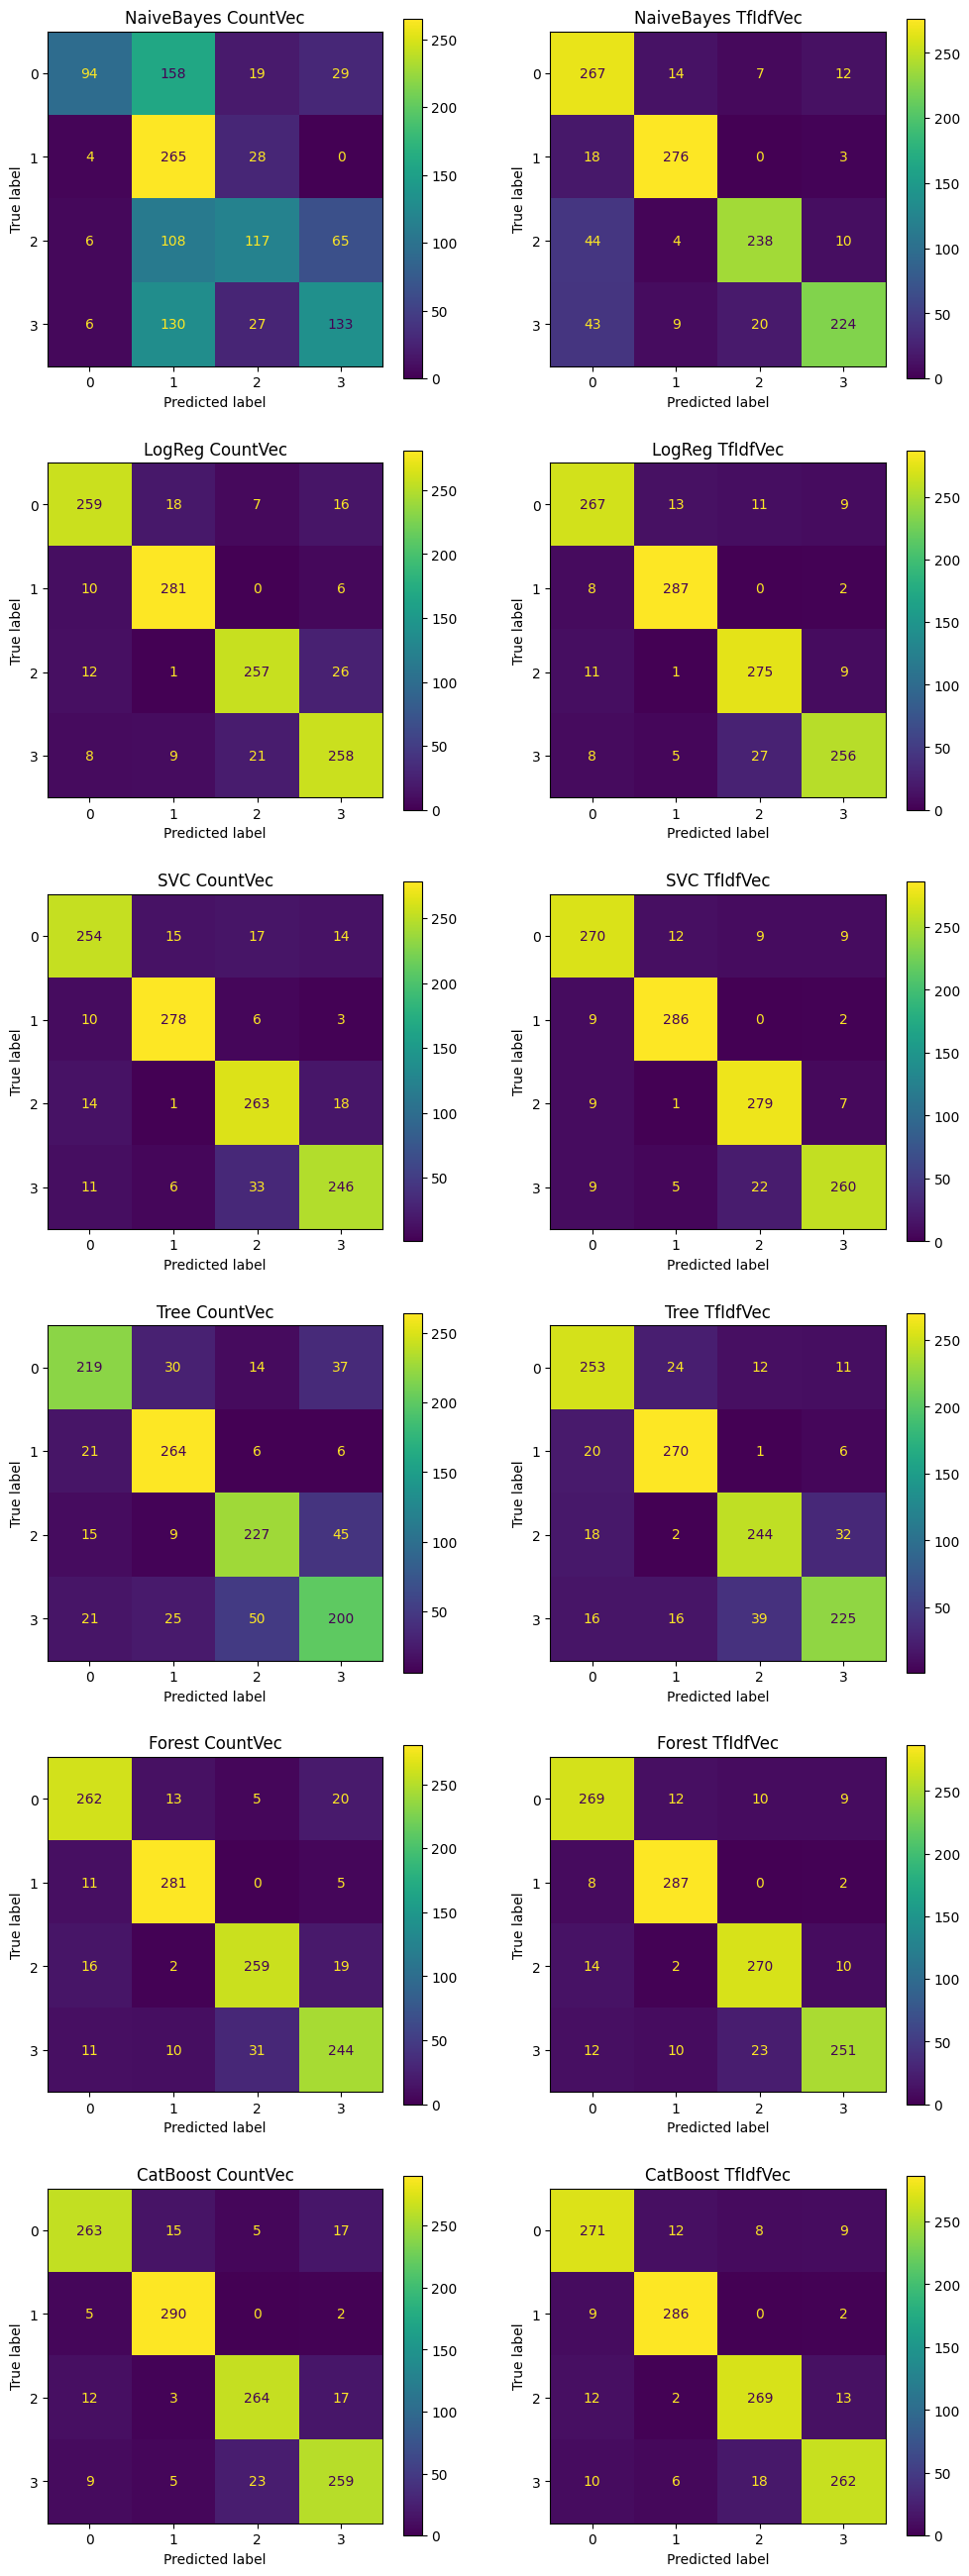

In [15]:
fig, ax = plt.subplots(6, 2, figsize=(12, 33))

ax[0][0].set_title("NaiveBayes CountVec")
ax[0][1].set_title("NaiveBayes TfIdfVec")
displays[0].plot(ax=ax[0][0])
displays[6].plot(ax=ax[0][1])

ax[1][0].set_title("LogReg CountVec")
ax[1][1].set_title("LogReg TfIdfVec")
displays[1].plot(ax=ax[1][0])
displays[7].plot(ax=ax[1][1])


ax[2][0].set_title("SVC CountVec")
ax[2][1].set_title("SVC TfIdfVec")
displays[2].plot(ax=ax[2][0])
displays[8].plot(ax=ax[2][1])

ax[3][0].set_title("Tree CountVec")
ax[3][1].set_title("Tree TfIdfVec")
displays[3].plot(ax=ax[3][0])
displays[9].plot(ax=ax[3][1])

ax[4][0].set_title("Forest CountVec")
ax[4][1].set_title("Forest TfIdfVec")
displays[4].plot(ax=ax[4][0])
displays[10].plot(ax=ax[4][1])

ax[5][0].set_title("CatBoost CountVec")
ax[5][1].set_title("CatBoost TfIdfVec")
displays[5].plot(ax=ax[5][0])
displays[11].plot(ax=ax[5][1])

#### Выводы по ConfusionMatrix
1. Наивный баес с CountVectorizer путает hr_managment(1) с остальными классами.
2. Все модели путают physics(2) и biotech(3) классы.
3. У всех моделей artificial_intelligence(0) имеет больше всего неправильно предсказанных текстов.
4. Все модели меньше всего путают классы hr_management(1) и physics(2).

### Подбор гиперпараметров для отобранных моделей.
**Ориентироваться будем на метрику f1-micro (micro, потому что классы сбалансированы)**

In [7]:
X = TfidfVectorizer().fit_transform(raw_documents=preprocessed_stems)
pca = PCA(n_components=50, random_state=54)
X = pca.fit_transform(X.toarray())
y = [class_mapper[cat] for cat in categories]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=54)

In [6]:
best_params_metrics, best_params_disp = [], []

In [ ]:
parameters = {'kernel':('linear', 'poly', 'rbf'), 
              'C':[1, 3, 5, 10],
              'degree': [1, 3, 5],
              'gamma': ['scale', 'auto']}

svc = SVC(probability=True)

svc_gs = GridSearchCV(svc, parameters, verbose=1, n_jobs=5, refit=True, scoring='f1_micro')
svc_gs.fit(X_train, y_train)

In [36]:
svc_gs.best_params_

{'C': 5, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [39]:
svc_model = svc_gs.best_estimator_
data, disp = train_model(model=svc_model, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        save_path='/kaggle/working/SVC_Tfidf_best_params.pkl')

In [40]:
best_params_metrics.append(data)
best_params_disp.append(disp)

In [ ]:
parameters = {'penalty':['l2', None], 
              'max_iter': [75, 100, 200, 400],
              'C':[1, 3, 7, 10],
              'tol': [1e-8, 1e-6, 1e-4],
              'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
             }

logreg = LogisticRegression(verbose=0)

logreg_gs = GridSearchCV(logreg, parameters, verbose=1, n_jobs=5, refit=True, scoring='f1_micro')
logreg_gs.fit(X_train, y_train)

In [43]:
logreg_gs.best_params_

{'C': 1,
 'max_iter': 75,
 'penalty': None,
 'solver': 'newton-cholesky',
 'tol': 1e-08}

In [44]:
logreg_model = logreg_gs.best_estimator_
data, disp = train_model(model=logreg_model, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        save_path='/kaggle/working/LogReg_Tfidf_best_params.pkl')


In [45]:
best_params_metrics.append(data)
best_params_disp.append(disp)

In [ ]:
parameters = {'learning_rate': [0.01, 0.05, 0.1],
                'depth': [4, 7, 10, 12],
                'l2_leaf_reg': [1, 3, 5, 7],
               }

cb = CatBoostClassifier(verbose=False, task_type="GPU")

cb_gs = GridSearchCV(cb, parameters, verbose=1, refit=True, scoring='f1_micro')
cb_gs.fit(X_train, y_train)

In [16]:
cb_gs.best_params_

{'depth': 4, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [18]:
cb_model = cb_gs.best_estimator_
data, disp = train_model(model=cb_model, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        save_path='/kaggle/working/CatBoost_Tfidf_best_params.pkl')

In [34]:
best_params_metrics.append(data)
best_params_disp.append(disp)

In [47]:
best_params_metrics_df = pd.DataFrame(np.array(best_params_metrics), columns=['model', 'vectorizer', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc_score'])

In [48]:
best_params_metrics_df

,model,vectorizer,accuracy,recall,precision,f1,roc_auc_score
0,CatBoostClassifier,TfidfVectorizer,0.9141951041951042,0.9142136248948697,0.9140114371430148,0.9139876854741745,0.9867355159547226
1,SVC,TfidfVectorizer,0.9276860951860952,0.9276703111858705,0.9276152347711996,0.9275007081430249,0.9870263740069347
2,LogisticRegression,TfidfVectorizer,0.9184461734461735,0.9184188393608074,0.9182403261092634,0.9181679956997622,0.9854311299980946


#### Метрики удалось чуть чуть улучшить, но не значительно, SVC все еще лучшая модель, а вот LogReg стал лучше, чем Сatboost 

### Интересно также посмотреть какие фичи были важны (feature importance)

In [117]:
fi_metrics, fi_disp = [], []

In [118]:
svc = SVC(probability=True, C=5, degree=1, gamma='scale', kernel='rbf').fit(X_train, y_train)
    
result = permutation_importance(
    svc, X_test, y_test, n_repeats=10, random_state=54, n_jobs=2, scoring='f1_micro'
)

svc_importances = pd.Series(result.importances_mean)

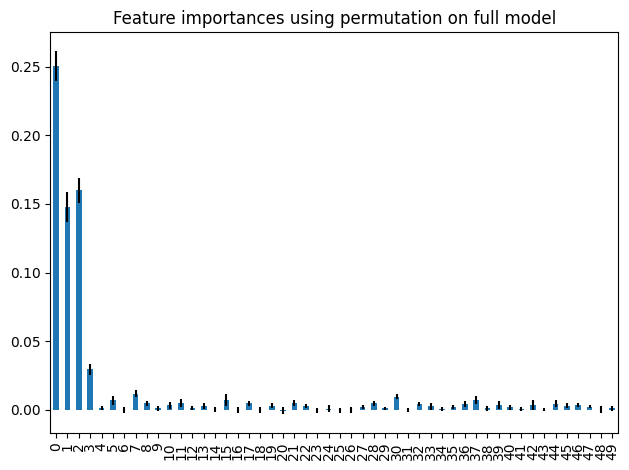

In [119]:
fig, ax = plt.subplots()
svc_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
fig.tight_layout()
plt.show()

In [120]:
importance_idx = (result.importances_mean > 0.002).nonzero()[0] 
fi_X_train = [arr[importance_idx] for arr in X_train]
fi_X_test = [arr[importance_idx] for arr in X_test]

In [121]:
fi_svc = SVC(probability=True, C=5, degree=1, gamma='scale', kernel='rbf')
data, disp = train_model(model=fi_svc, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=fi_X_train, y_train=y_train,
                        X_test=fi_X_test, y_test=y_test,
                        save_path='./models/lab2/fi_SVC_Tfidf_best_params.pkl')

fi_metrics.append(data)

In [122]:
fi_cb = CatBoostClassifier(verbose=False, depth=4, l2_leaf_reg=1, learning_rate=0.1).fit(X_train, y_train)
    
result = permutation_importance(
    fi_cb, X_test, y_test, n_repeats=10, random_state=54, n_jobs=2, scoring='f1_micro'
)

cb_importances = pd.Series(result.importances_mean)

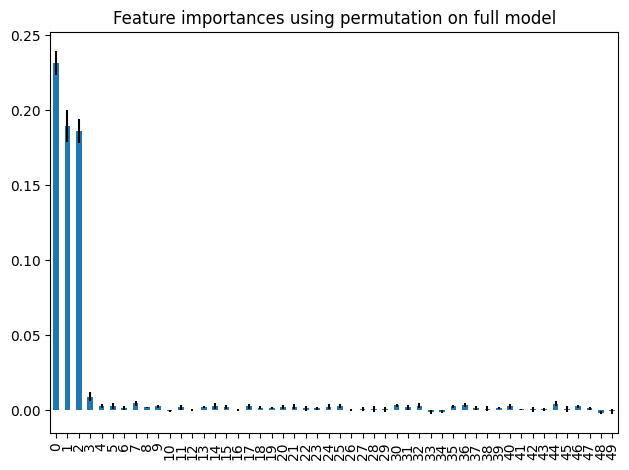

In [123]:
fig, ax = plt.subplots()
cb_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
fig.tight_layout()
plt.show()

In [124]:
importance_idx = (result.importances_mean > 0.0005).nonzero()[0] 
fi_X_train = [arr[importance_idx] for arr in X_train]
fi_X_test = [arr[importance_idx] for arr in X_test]

In [125]:
fi_cb = CatBoostClassifier(verbose=False, depth=4, l2_leaf_reg=1, learning_rate=0.1)
data, disp = train_model(model=fi_cb, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=fi_X_train, y_train=y_train,
                        X_test=fi_X_test, y_test=y_test,
                        save_path='./models/lab2/fi_CatBoost_Tfidf_best_params.pkl')

fi_metrics.append(data)

In [126]:
fi_logreg = LogisticRegression(verbose=0, C=1, max_iter=75, penalty=None, solver='newton-cholesky', tol=1e-08).fit(X_train, y_train)
    
result = permutation_importance(
    fi_logreg, X_test, y_test, n_repeats=10, random_state=54, n_jobs=2, scoring='f1_micro'
)

logreg_importances = pd.Series(result.importances_mean)

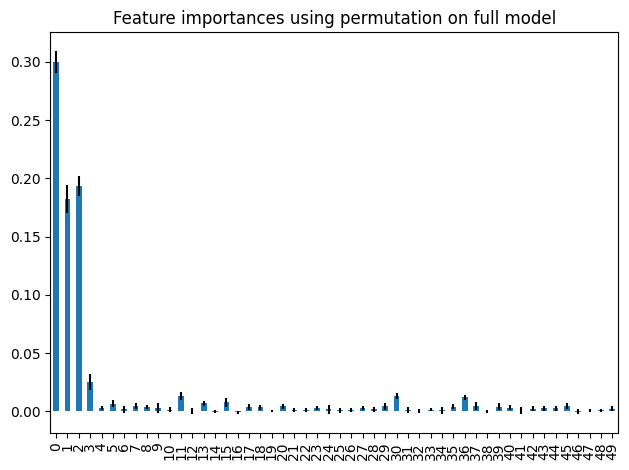

In [127]:
fig, ax = plt.subplots()
logreg_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
fig.tight_layout()
plt.show()

In [128]:
importance_idx = (result.importances_mean > 0.002).nonzero()[0] 
fi_X_train = [arr[importance_idx] for arr in X_train]
fi_X_test = [arr[importance_idx] for arr in X_test]

In [129]:
fi_logreg = LogisticRegression(verbose=0, C=1, max_iter=75, penalty=None, solver='newton-cholesky', tol=1e-08)
data, disp = train_model(model=fi_logreg, 
                        vectorizer_name=TfidfVectorizer().__class__.__name__, 
                        X_train=fi_X_train, y_train=y_train,
                        X_test=fi_X_test, y_test=y_test,
                        save_path='./models/lab2/fi_LogReg_Tfidf_best_params.pkl')

fi_metrics.append(data)

In [130]:
fi_metrics_df = pd.DataFrame(np.array(fi_metrics), columns=['model', 'vectorizer', 'accuracy', 'recall', 'precision', 'f1', 'roc_auc_score'])
fi_metrics_df

,model,vectorizer,accuracy,recall,precision,f1,roc_auc_score
0,SVC,TfidfVectorizer,0.9335503685503685,0.9335576114381834,0.9335944406768307,0.9334220413855462,0.9854132176726624
1,CatBoostClassifier,TfidfVectorizer,0.9209236509236509,0.9209419680403701,0.9208773313288086,0.9206930780267546,0.9869547696450174
2,LogisticRegression,TfidfVectorizer,0.9201410501410502,0.9201009251471826,0.9205250287669794,0.919854652794126,0.9854787009391306


#### Результаты SVC улучшилось почти на 1 во всех метриках кроме roc_auc_score, другие модели тоже стали лучше, но прирост меньше 1, CatBoost снова обогнал LogReg